<a href="https://colab.research.google.com/github/Fansesi/tubitak_2204A/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "./drive/MyDrive/chick_dataset/dataset.zip" "."

In [ ]:
!unzip "dataset.zip"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
PATH = '/content/dataset'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

print(train_dir)
print(validation_dir)

/content/dataset/train
/content/dataset/val


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 6155 files belonging to 4 classes.
Found 683 files belonging to 4 classes.


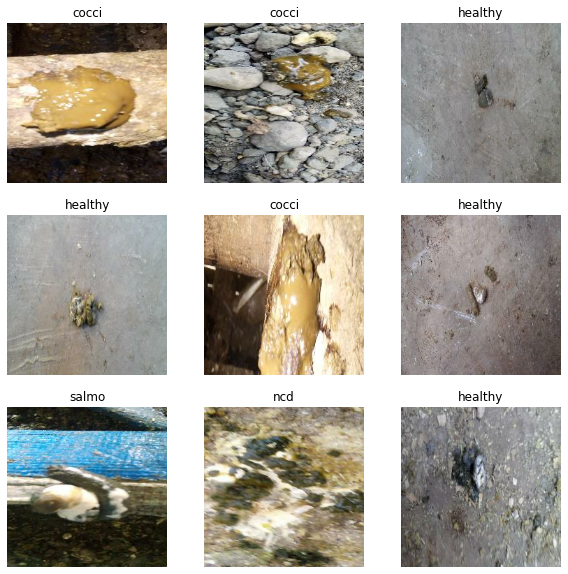

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 18
Number of test batches: 4


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
print(IMG_SHAPE)
print(IMG_SIZE)

(160, 160, 3)
(160, 160)


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False
#base_model.summary()


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [ ]:


inputs = tf.keras.layers.Input(shape = (160,160,3), name='inputLayer')
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = tf.keras.layers.Dense(4, name='outputLayer')(x)
outputs = tf.keras.layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)


Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 outputLayer (Dense)         (None, 4)                 5124      
                                                                 
 activationLayer (Activation  (None, 4)                0         
 )                                                               
                                            

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


18/18 [==============================] - 3s 54ms/step - loss: 1.8033 - accuracy: 0.1297
initial loss: 1.80
initial accuracy: 0.13


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
193/193 [==============================] - 14s 56ms/step - loss: 1.0780 - accuracy: 0.5413 - val_loss: 0.7712 - val_accuracy: 0.7135
Epoch 2/10
193/193 [==============================] - 11s 56ms/step - loss: 0.7203 - accuracy: 0.7436 - val_loss: 0.6353 - val_accuracy: 0.7622
Epoch 3/10
193/193 [==============================] - 11s 57ms/step - loss: 0.6350 - accuracy: 0.7708 - val_loss: 0.5660 - val_accuracy: 0.7856
Epoch 4/10
193/193 [==============================] - 11s 56ms/step - loss: 0.5863 - accuracy: 0.7862 - val_loss: 0.5336 - val_accuracy: 0.7964
Epoch 5/10
193/193 [==============================] - 11s 57ms/step - loss: 0.5534 - accuracy: 0.7974 - val_loss: 0.5163 - val_accuracy: 0.8108
Epoch 6/10
193/193 [==============================] - 11s 57ms/step - loss: 0.5277 - accuracy: 0.8068 - val_loss: 0.4987 - val_accuracy: 0.8270
Epoch 7/10
193/193 [==============================] - 11s 57ms/step - loss: 0.5076 - accuracy: 0.8130 - val_loss: 0.4649 - val_accuracy:

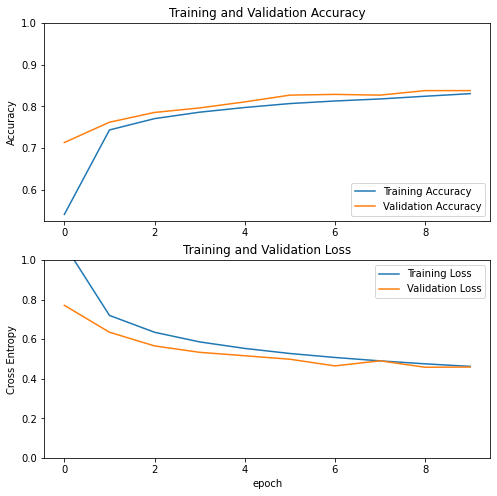

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/chick_dataset/model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/chick_dataset/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/chick_dataset/model/assets


In [ ]:
preds = model.predict(test_dataset, verbose = 1)

4/4 [==============================] - 0s 57ms/step


In [ ]:
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:4]

test_labels = tf.argmax(preds, axis=1)
test_labels[:4]

# Step 1
test_image_batches = []
for images, labels in test_dataset.take(-1):
    test_image_batches.append(images.numpy())

# Step 2
test_images = [item for sublist in test_image_batches for item in sublist]
len(test_images)

128

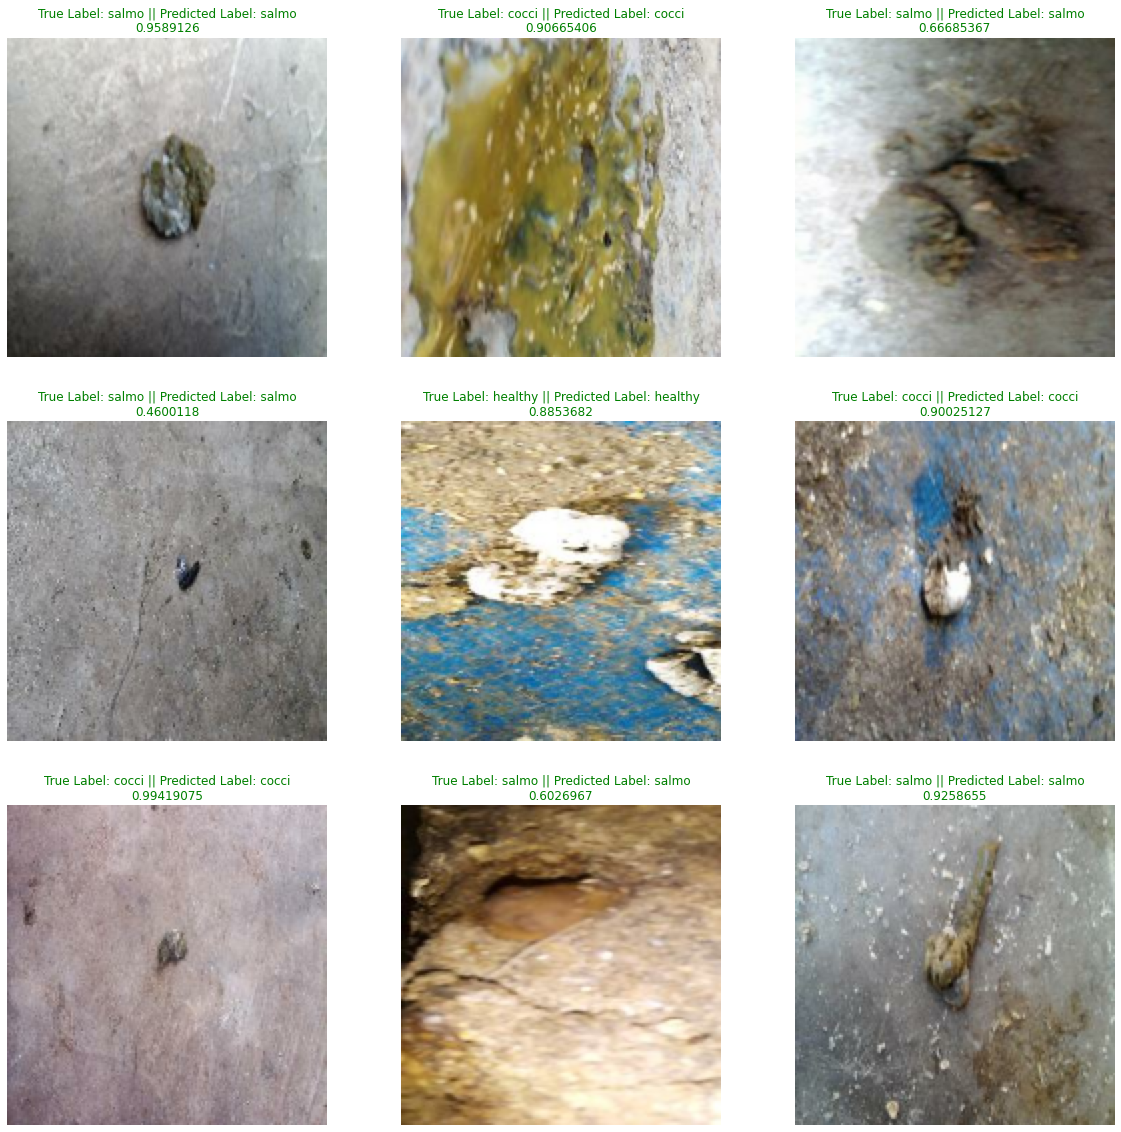

In [ ]:
import random
plt.figure(figsize = (20,20))
for i in range(9):
    random_int_index = random.choice(range(len(test_images)))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[random_int_index]/255.)
    if test_labels[random_int_index] == pred_labels[random_int_index]:
        color = "g"
    else:
        color = "r"
    plt.title("True Label: " + class_names[test_labels[random_int_index]] + " || " + "Predicted Label: " +
              class_names[pred_labels[random_int_index]] + "\n" + 
              str(np.asarray(tf.reduce_max(preds, axis = 1))[random_int_index]), c=color)
    plt.axis(False);